# 1. Definition
## 1.1 Project Overview
From December 2008 until December 2018, the mean property prices in all of Norway have increased by 82%. However, for the region of Oslo, the growth for the same period was 121%[[1]](https://krogsveen.no/Boligprisstatistikk/(county)/Oslo 'Krogsveen Norge'). This complication makes the purchase of property in the biggest urban center in Norway a process having an inherent financial risk.

The purpose of this project is to provide a comprehensive view of the property market of Oslo and Akershuhs. Such analysis would inform a prudent purchase of real estate by the user in the above-mentioned areas. The main goals of investigation for the analysis are to:
* Estimate a reasonable price per square meter in various parts of Oslo and Akershus
* Understand the factors that have the highest influence on the price per square meter
* Detect areas with overvalued and undervalued real estate prices
* Find and recommend properties suitable for purchase based on the findings from this analysis

The datasets used in this analysis are:
* Real estate dataset
* Post codes dataset
* Google places dataset
* Dataset by the National Health Institute referred to also as FHI

## 1.2 Problem Statement
We need to identify patterns and relationships between various real estate features (e.g. size, number of floors, energy characteristics) and the target (price per square meter). In addition, we need to identify potential neighborhood features to augment the real estate dataset.

## 1.3 Metrics
Since our problem requires the prediction of the target value, we will utilize the following regression metrics:
* Mean Squared Error
* Median Squared Error
* Max Error
* Explained Variance
* R2 Score

# 2. Analysis
## 2.1 Data Exploration
### 2.1.1 Real Estate Dataset
We will start by importing the libraries we will utilize.

In [1]:
import pandas as pd
import numpy as np
from sklearn import feature_selection
from sklearn import preprocessing as preprocess
from sklearn import linear_model
from sklearn import pipeline
from google.cloud import bigquery
import matplotlib.pyplot as plt
import seaborn as sns
import folium
from folium import plugins
import datashader as ds
from datashader import transfer_functions as tf
from datashader.colors import colormap_select, Greys9, Hot, inferno
from datashader.bokeh_ext import InteractiveImage
from bokeh.tile_providers import get_provider, Vendors
from bokeh.models import GMapOptions
from bokeh.plotting import figure, output_notebook, show, gmap
from bokeh.models import BoxZoomTool
from pyproj import Proj, transform
import utils as u

Next, we will set up our visual style for the rest of the notebook.

In [2]:
pd.set_option('display.max_colwidth', 20)
pd.set_option('display.max_columns', 40)
pd.set_option('display.max_rows', 40)
from IPython.display import display, HTML
%matplotlib inline
sns.set(style='dark')
plt.rcParams['figure.figsize'] = [14, 10]

We will now import the main dataset.

In [3]:
queries = u.get_queries('queries')

In [4]:
bq_client = bigquery.Client()

In [5]:
data = u.get_data(queries, 'all_existing_building_ads.sql', bq_client)

In [6]:
data.iloc[:, 2:].head()

floor  primary_size  total_size      price property_type   ownership_type  \
0    4.0          70.0        81.0  3104597.0     Leilighet            Andel   
1   11.0          77.6         NaN  7337214.0     Leilighet  Eier (Selveier)   
2    NaN           NaN         NaN  3446452.0     Leilighet  Eier (Selveier)   
3    5.0          83.0       116.0  3555488.0     Leilighet            Andel   
4    NaN         216.0       353.0  9188749.0      Enebolig  Eier (Selveier)   

   construction_year energy_character  common_expenses  brokerage_expenses  \
0             1967.0    F -mørkegrønn           5130.0              7615.0   
1             2019.0             None           2450.0            187214.0   
2                NaN             None           1769.0             56452.0   
3             1978.0             None           4977.0             14488.0   
4             1984.0           F -gul              NaN            238749.0   

   common_wealth  common_debt              address  
0        68326.0     396982.0  Ammerudveien 62,...  
1            NaN          NaN  Ensjø Torg, leil...  
2            NaN          NaN  Lundkvartalet, 2...  
3        13510.0     191000.0  Lindebergåsen 5 ...  
4            NaN          NaN  Selvbyggerveien ...

We now need to inspect the number of missing values per feature.

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2285 entries, 0 to 2284
Data columns (total 15 columns):
ad_id                 2285 non-null int64
num_bedrooms          2199 non-null float64
floor                 1720 non-null float64
primary_size          2278 non-null float64
total_size            2055 non-null float64
price                 2152 non-null float64
property_type         2285 non-null object
ownership_type        2285 non-null object
construction_year     2271 non-null float64
energy_character      1851 non-null object
common_expenses       1804 non-null float64
brokerage_expenses    2149 non-null float64
common_wealth         1268 non-null float64
common_debt           1275 non-null float64
address               2285 non-null object
dtypes: float64(10), int64(1), object(4)
memory usage: 267.9+ KB


As we can see, there are only 2 complete fields. Since our target is defined as price per square meter, we need to limit ourselves to the cases where both the `primary_size` and the `price` of each real estate object are present.

In [8]:
data = data[(data.price.notna()) & (data.primary_size.notna())].copy()

We can now sort and plot the features by the number of `NULL` values.

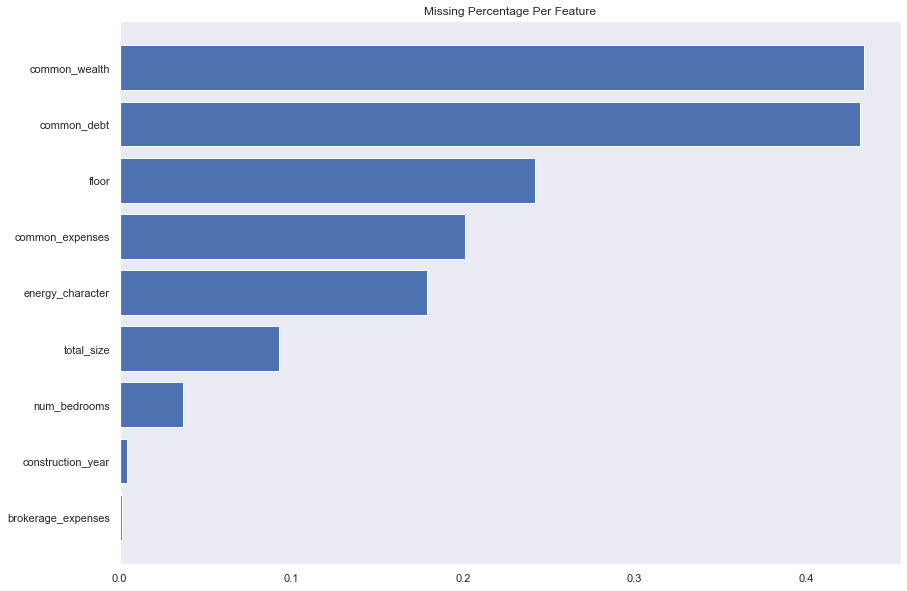

In [18]:
# to_plot = data.isna().sum(axis=0).drop(['ad_id', 'apt_id']) / len(data)
to_plot = data.isna().sum(axis=0).drop(['ad_id']) / len(data)
to_plot = to_plot[to_plot > 0].sort_values()

top_missing_columns = list(to_plot[to_plot > to_plot.mean()].index)

plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Missing Percentage Per Feature')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

As we can see, the features with the least number of `NULL` values are: `construction_year`, `num_bedrooms`, `total_size` (expected as we filtered the missing `primary_size` values) and `address`. Conversely, the features with highes percentage of missing values are: `common_wealth`, `common_expenses`, `common_debt`, `brokerage_expenses` and `energy_character`.

It is worth mentioning that it is possible that a missing value for: `common_wealth`, `common_expenses`, `common_debt` and `brokerage_expenses` may mean that there are no such expenses / debt / eatlh (i.e. 0). We will investigate that further.

The `floor` column has about 20% (as of the time of writing of this analysis) missing values. It may be possible to infer and impute the value for this feature. Again, we will investigate that further on.

Let us now look at the distribution of `common_wealth`, `common_expenses`, `common_debt` and `brokerage_expenses`:

In [19]:
data[top_missing_columns].describe()

common_expenses        floor   common_debt  common_wealth
count      1715.000000  1627.000000  1.220000e+03   1.216000e+03
mean       3509.343440     2.907191  2.136904e+05   3.027326e+04
std        1588.462354     1.802176  3.635222e+05   8.336939e+04
min          83.000000     1.000000  1.000000e+00   3.280000e+02
25%        2530.500000     2.000000  4.950575e+04   1.099275e+04
50%        3300.000000     3.000000  1.200010e+05   1.865200e+04
75%        4159.500000     4.000000  2.226128e+05   3.190500e+04
max       17217.000000    20.000000  5.189408e+06   1.905469e+06

As we can see, the minimum values for `brokerage_expenses` and `common_debt` are 0, which means that we cannot treat missing values as 0 too. The `common_expenses` and `common_wealth`, on the other hand have minimum values higher than 0. This means that we can investigate the latter columns further and drop the former.

One way to gain further understanding of the meaning of `NULL` values within the `common_expenses` and `common_wealth` fields is to show their aggregate values by property type. Our intuition here is that different properties are associated with different expenses and wealth.

In [20]:
data.drop(['brokerage_expenses', 'common_debt', 'energy_character'], axis=1, inplace=True)

In [21]:
pd.pivot_table(data=data, index='property_type', values=['common_expenses', 'common_wealth'], aggfunc=['min', 'median', 'max'])

min                        median                \
              common_expenses common_wealth common_expenses common_wealth   
property_type                                                               
Enebolig                 83.0       11366.0           900.0       41444.0   
Leilighet               250.0         328.0          3319.0       18571.5   
Rekkehus                500.0        3095.0          2986.5       19488.0   
Tomannsbolig            500.0        8408.0          3054.5       12854.0   

                          max                
              common_expenses common_wealth  
property_type                                
Enebolig              15000.0      101378.0  
Leilighet             17217.0     1905469.0  
Rekkehus               6662.0      388170.0  
Tomannsbolig           4840.0       54094.0

Apparently, one of the maximum values is an outlier (the maximum `common_wealth` for apartments). We can display the 5 highest values and see the difference between the maximum and the second, third and fourth biggest:

In [22]:
data.common_wealth.dropna().sort_values().tail()

209      388170.0
1456     441403.0
2052     508604.0
1700    1864592.0
1145    1905469.0
Name: common_wealth, dtype: float64

In [23]:
nth_biggest = data.common_wealth.dropna().sort_values().iloc[-4]

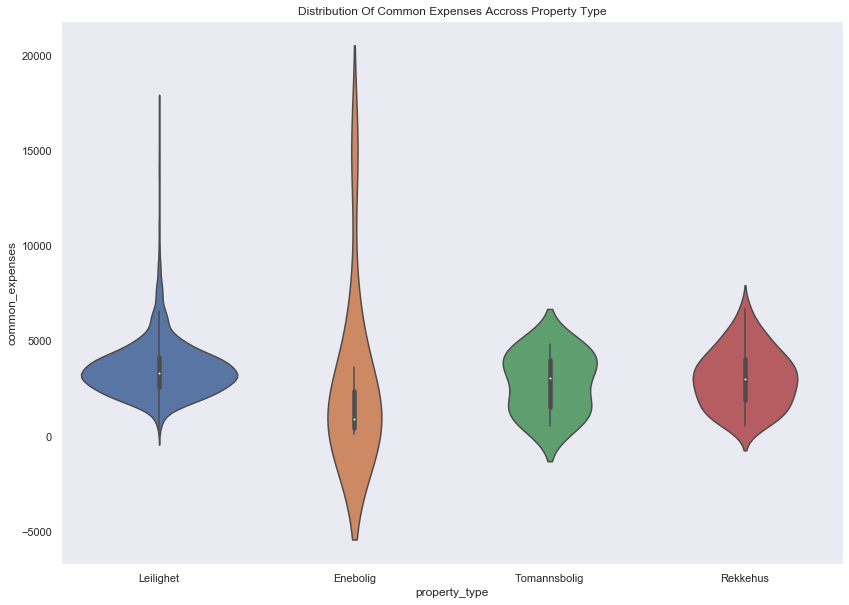

In [24]:
to_plot = data[['common_expenses', 'property_type']]
sns.violinplot(data=to_plot, x='property_type', y='common_expenses')
plt.title('Distribution Of Common Expenses Accross Property Type')
plt.show()

It seems like the common expenses vary with the type of property (considering mainly apartments, terraced houses and detached houses as other property types present a very thin selection). With a median common expenses for apartments in exccess of 3000, it seems unjustified to impute the missing values with 0. Moreover, one should expect that most real estate objects have common expenses (municipal fees, water, etc.).

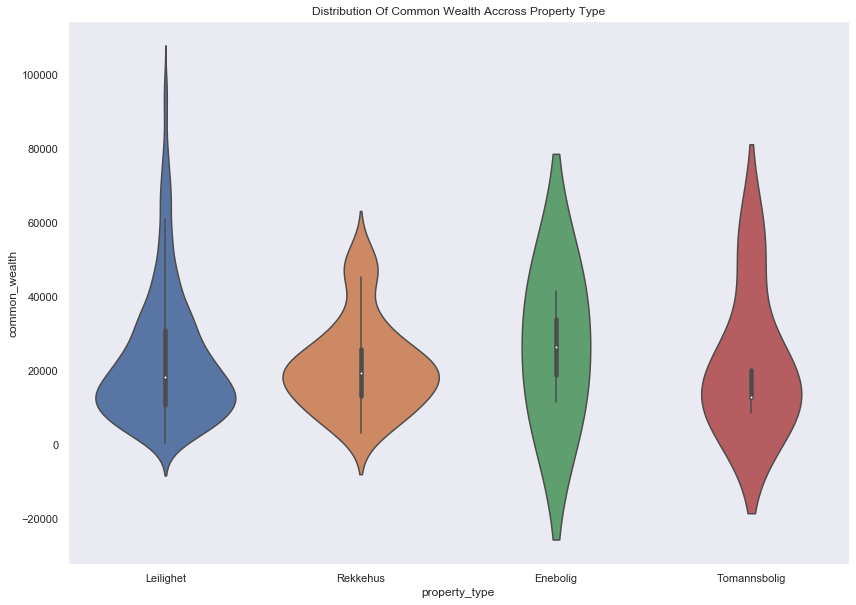

In [25]:
to_plot = data[data.common_wealth < 1e5][['common_wealth', 'property_type']]
sns.violinplot(data=to_plot, x='property_type', y='common_wealth')
plt.title('Distribution Of Common Wealth Accross Property Type')
plt.show()

We had to limit our selection to values below 100000 as a the apartment series' distribution has a very long tail. No specific pattern can be observed here. However, since `common_wealth` is not usually present for most real estate objects, we can impute it with zero values. We can then further inspect the correlation with it and the target.

In [26]:
data.drop('common_expenses', axis=1, inplace=True)

In [27]:
data['common_wealth'] = data['common_wealth'].fillna(0)

We will now derive the `post_code` of each real estate object from its address. In addition we will calculate our target - namely the price per square meter.

In [28]:
data['post_code'] = data.address.apply(u.get_postcode_from_address)

In [29]:
data['price_per_sq_m'] = data.price.div(data.primary_size).round(0)

We will now augment the data by adding 3 new columns (constituting 2 new features):
* travel time - the number of seconds of travel from the the address of the real estate object to the central transportation hub of Oslo by using public transit
* latitutde and longitude of the real estate object

In [32]:
travel_time = u.get_data(queries, 'coordinates_and_travel_times.sql', bq_client).set_index('ad_id')

In [33]:
travel_time.head()

time_s        lat        lng
ad_id                                   
NaN            NaN        NaN        NaN
69757913.0  2771.0  59.807806  10.882621
71962400.0  1939.0  59.941283  10.979730
76674446.0  1690.0  59.956185  11.054666
77962792.0  2441.0  59.926221  10.494106

The number missing values in this mini-dataset is directly dependent on the number of missing values in the `address` field of the real estate dataset as well as the responses from the Google Maps API. Since our `address` field had only 2 missing records (as of the time of this writing), we can proceed and merge the `travel_time` dataset witht he real estate data.

In [34]:
data = data.merge(travel_time, how='left', left_on='ad_id', right_index=True)

Having the travel time allows us to hypothesize that convenience (i.e. short travel time) will have some explanatory power with regards to the target. Therefore, we will perform a simple, linear fit of the `time_s` and the `price_per_sq_m` columns. We prefer this approach to Seaborn's `jointplot` as having made the fit ourselves will allow us to use the intercept and slope of the line later on.

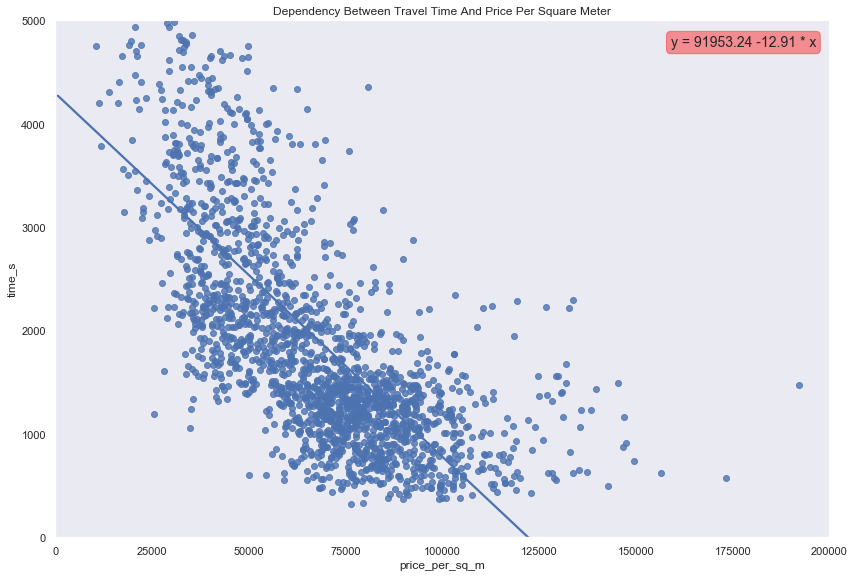

In [35]:
reg = linear_model.LinearRegression(normalize=True)

# new buildings containing several apartments have the exact same
# travel time, but different prices
# aggregate by building and take the mean price_per_sq_m

to_plot = data.groupby('ad_id').mean()[['time_s', 'price_per_sq_m']].dropna()
to_plot_X = to_plot.time_s.values.reshape(-1, 1)
to_plot_y = to_plot.price_per_sq_m.values.reshape(-1, 1)

reg.fit(to_plot_X, to_plot_y)

intercept = reg.intercept_[0]
coef = reg.coef_[0][0]

g = sns.lmplot(x='price_per_sq_m', y='time_s', data=to_plot, fit_reg=True, aspect=1.5, ci=None, height=8)

g.axes[0,0].set_ylim(0, 5e3)
g.axes[0,0].set_xlim(0, 2e5)

g.ax.text(0.795, 0.95, f'y = {intercept:.2f} {coef:.2f} * x',
          transform=g.ax.transAxes, fontsize=14,
          bbox=dict(boxstyle='round', alpha=0.4,color='red'))

plt.title('Dependency Between Travel Time And Price Per Square Meter')
plt.show()

In [36]:
print(f'The r2 score based only on travel time is: {reg.score(to_plot_X, to_plot_y):.2f}')

The r2 score based only on travel time is: 0.45


The `time_s` is definitely a feature worth using. We can now turn our attention towards the coordinates of each real estate object. We can convert those coordinates to `web_mercator` format and overlay the results on top of the map of Oslo. In addition we can add a color gradient to each set of coordinates, indicating the scaled `price_per_sq_m`.

In [37]:
%%time
web_lat = []
web_lng = []
index = []
to_plot = data.groupby('ad_id')
for lat, lng, i in zip(to_plot.lat.median(), to_plot.lng.median(), to_plot.lat.median().index):
    _web_lng, _web_lat = transform(Proj(init='epsg:4326'), Proj(init='epsg:3785'), lng, lat)
    web_lat.append(_web_lat)
    web_lng.append(_web_lng)
    index.append(i)

CPU times: user 1min 43s, sys: 11.7 s, total: 1min 54s
Wall time: 1min 54s


In [38]:
web_mercator = pd.DataFrame({'web_lat': web_lat, 'web_lng': web_lng}, index=index)

In [39]:
data = data.merge(web_mercator, how='left', left_on='ad_id', right_index=True)

In [40]:
x_range, y_range = ((1168606.2995454127, 1207069.187365323),
                    (8368810.8718011845, 8390129.272570336))

plot_width  = int(1200)
plot_height = int(plot_width//2.2)

In [41]:
def base_plot(tools='pan,wheel_zoom,reset', plot_width=plot_width, plot_height=plot_height, **plot_args):
    p = figure(tools=tools, plot_width=plot_width, plot_height=plot_height,
               x_range=x_range, y_range=y_range, x_axis_type='mercator', y_axis_type='mercator', outline_line_color=None,
               min_border=0, min_border_left=0, min_border_right=0,
               min_border_top=0, min_border_bottom=0, **plot_args)

    p.axis.visible = False
    p.xgrid.grid_line_color = None
    p.ygrid.grid_line_color = None

    p.add_tools(BoxZoomTool(match_aspect=True))

    return p

In [42]:
def create_image(x_range, y_range, w=plot_width, h=plot_height):
    cvs = ds.Canvas(plot_width=w, plot_height=h, x_range=x_range, y_range=y_range)
    agg = cvs.points(data, 'web_lng', 'web_lat',  ds.mean('price_per_sq_m'))
    img = tf.shade(agg, cmap=['pink', 'darkred'], alpha=150, how='eq_hist')
    return tf.dynspread(img, threshold=.3, shape='circle')

In [43]:
output_notebook()

p = base_plot()
p.add_tile(get_provider(Vendors.CARTODBPOSITRON_RETINA))
InteractiveImage(p, create_image)

Loading BokehJS ...

The map above is presents an interesting way of exploring individual real estate objects. However, if we want to present an aggregated view per neighborhood or settlement, we would need the corresponding area names. To do that, we will import another dataset containing them.

In [44]:
post_codes = u.get_data(queries, 'post_code_area_name.sql', bq_client).set_index('post_code')

In [45]:
data = data.merge(post_codes, how='left', left_on='post_code', right_index=True)

In addition, we can also separate the urban addresses (the ones within the municipality of Oslo) from the suburban ones.

In [46]:
data['address_oslo'] = data['settlement_name'].apply(lambda s_n: 1 if s_n == 'oslo' else 0)

We can now plot the median property price by area name in and outside of Oslo.

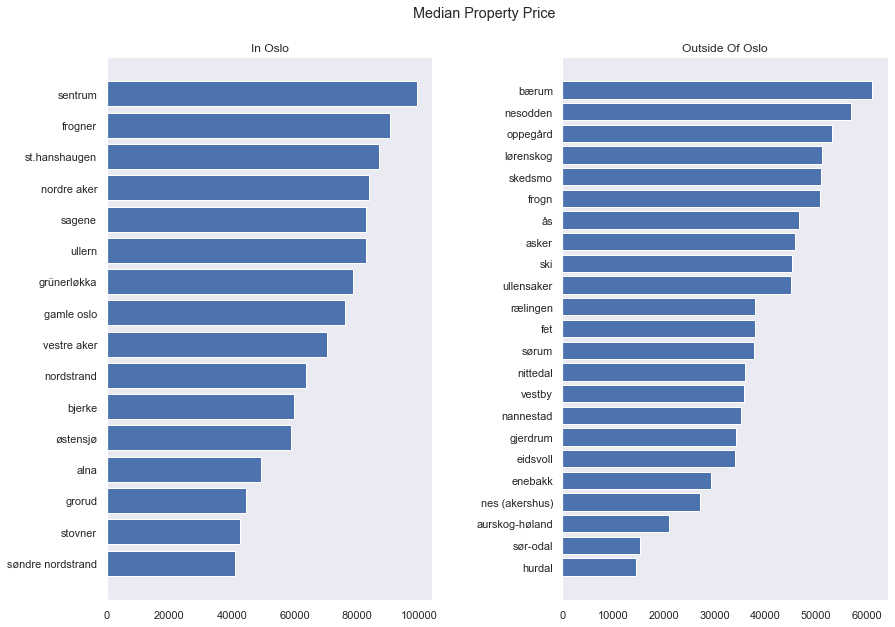

In [47]:
fig = plt.figure()
for i, _osl in enumerate(data.address_oslo.unique()):
    ax = plt.subplot(1, 2, i+1)
    to_plot = data[data.address_oslo == _osl].groupby('area_name').median()['price_per_sq_m'].sort_values()
    ax.set_yticks(range(len(to_plot)))
    ax.set_yticklabels(to_plot.index)
    ax.set_title('{} Oslo'.format('In' if _osl == 1 else 'Outside Of'))
    ax.barh(range(len(to_plot)), to_plot)
plt.subplots_adjust(wspace=0.4)
plt.suptitle('Median Property Price', y=0.95)
plt.show()

Real estate prices could differ based on the property type (house or apartment). We will now investigate the distribution of the property price by property type.

In [48]:
data['property_type_apartment'] = [0 if pt in ['Enebolig', 'Rekkehus', 'Tomannsbolig']
                                   else 1 if pt == 'Leilighet'
                                   else np.nan
                                   for pt in data['property_type']]

In [49]:
print('There are {} properties that are neither houses nor apartments.'.format(len(data[data.property_type_apartment.isna()])))

There are 0 properties that are neither houses nor apartments.


In [50]:
data = data[data.property_type_apartment.notnull()].copy()

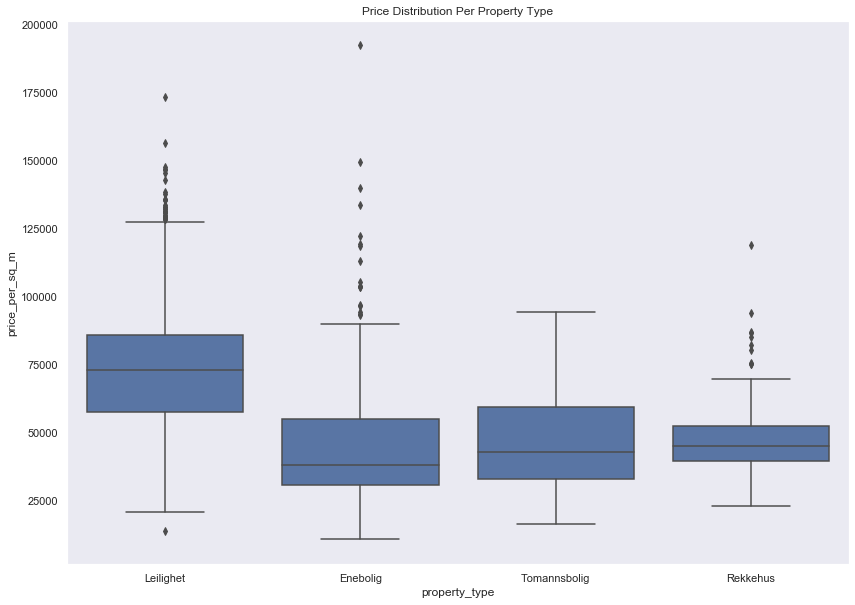

In [51]:
sns.boxplot(data=data, x='property_type', y='price_per_sq_m', color='b')
plt.title('Price Distribution Per Property Type')
plt.show()

As we can see, the property type is definitely informative of the price per square meter. There is apparently a difference between the price of apartments and houses, but there is little difference between the price distribution of the 3 house types (detached, semi-detached and terraced). Therefore, we can simply use a flag for apartments.

Another thing worth noting is that apartments have a large number of outliers. It is worth looking at those and understanding the reason for these values.

In [52]:
stdev = data[data.property_type_apartment == 1].price_per_sq_m.std()
mean = data[data.property_type_apartment == 1].price_per_sq_m.mean()
upper_cutoff = (stdev * 3) + mean
print('There are {} apartments with a price per square meter higher than {:.0f}.'.format(len(data[(data.property_type_apartment == 1)
                                                                                                  & (data.price_per_sq_m > upper_cutoff)]),
                                                                                         upper_cutoff))

There are 9 apartments with a price per square meter higher than 136823.


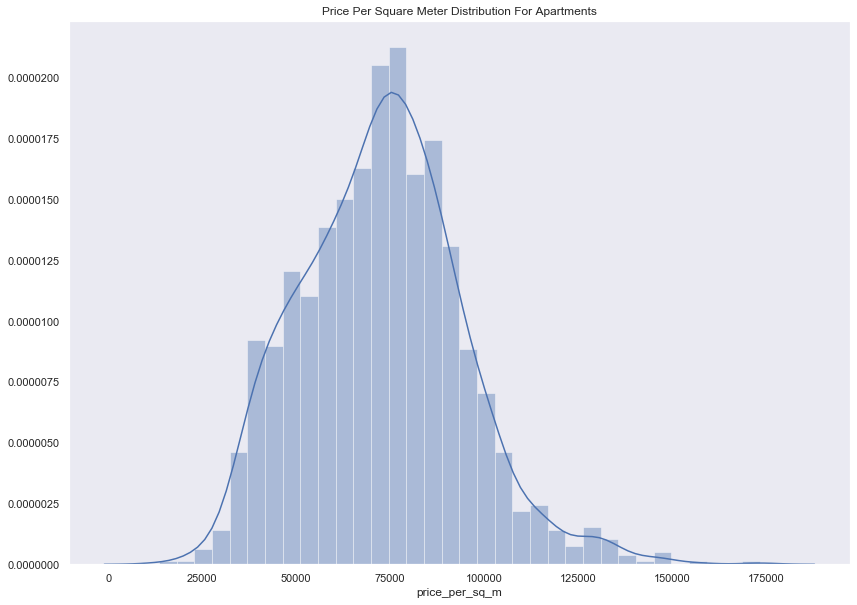

In [53]:
sns.distplot(data[data.property_type_apartment == 1]['price_per_sq_m'], norm_hist=True)
plt.title('Price Per Square Meter Distribution For Apartments')
plt.show()

As we can see, the distribution has a long tail and some properties have a price of over 250000 per square meter! Let us inspect a few examples of outlier apartments.

In [54]:
apt_columns_of_interest = ['construction_year', 'num_bedrooms', 'floor', 'primary_size', 'price_per_sq_m', 'ownership_type', 'area_name', 'common_wealth']
to_plot = data[(data.property_type_apartment == 1) & (data.price_per_sq_m > upper_cutoff)][apt_columns_of_interest].copy()
to_plot['ownership_full'] = [1 if ownership_type == 'Eier (Selveier)' else 0
                             for ownership_type in to_plot.ownership_type]
to_plot.drop('ownership_type', axis=1, inplace=True)

to_plot.head()

construction_year  num_bedrooms  floor  primary_size  price_per_sq_m  \
214             1954.0           0.0    3.0          15.0        145380.0   
304             2019.0           2.0    1.0         130.0        146545.0   
357             1966.0           0.0    5.0          14.0        138314.0   
383             1919.0           2.0    NaN         145.0        173306.0   
894             1939.0           3.0    3.0          87.0        147380.0   

       area_name  common_wealth  ownership_full  
214       sagene        11842.0               0  
304      frogner            0.0               1  
357  nordre aker        31889.0               0  
383      frogner        19325.0               1  
894       ullern            0.0               1

Let us look at the typical values of the columns above for our outliers.

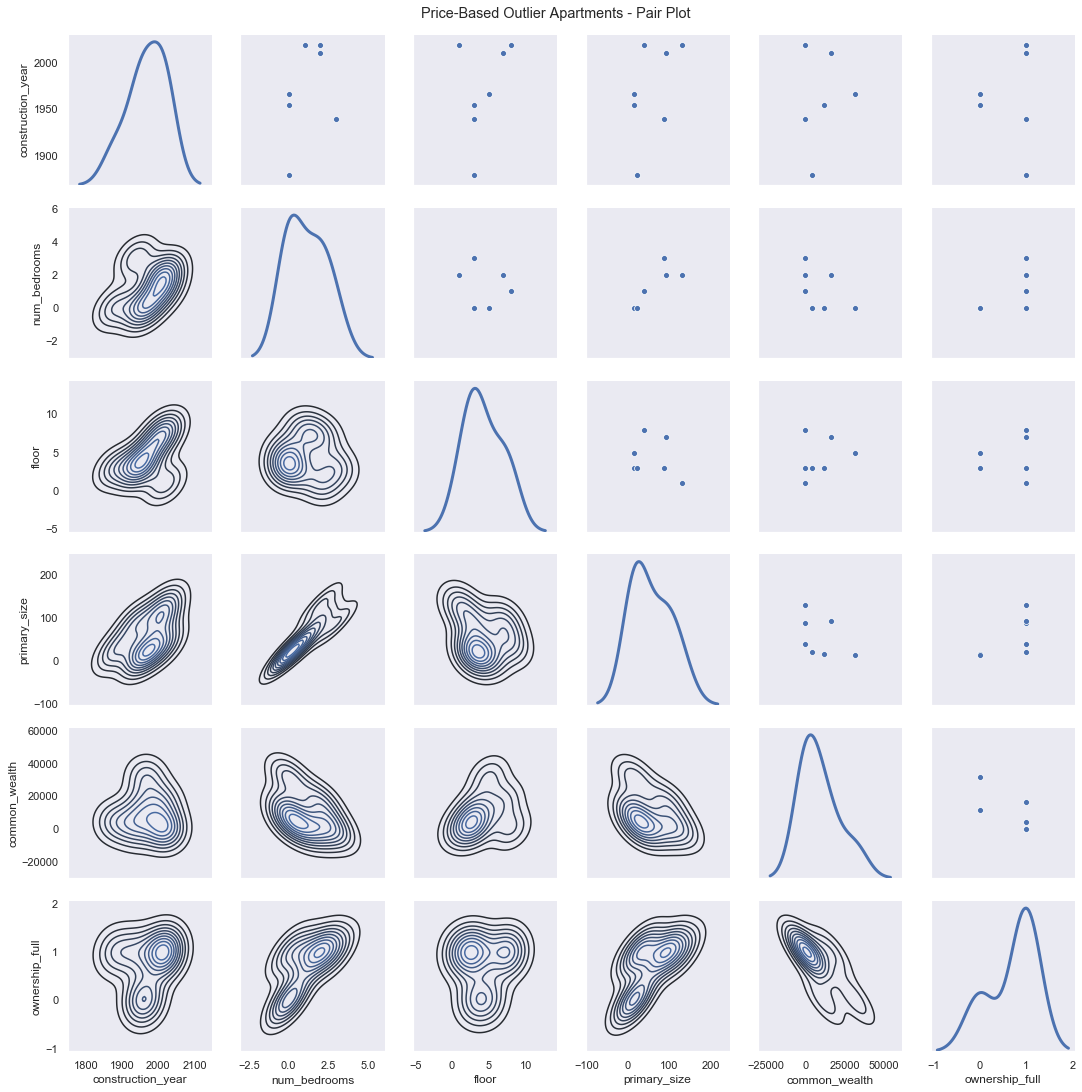

In [57]:
g = sns.PairGrid(to_plot.drop(['area_name', 'price_per_sq_m'], axis=1).dropna(), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(sns.kdeplot, lw=3)
plt.suptitle('Price-Based Outlier Apartments - Pair Plot', y=1.01)
plt.show()

There are several points worth mentioning here, namely:
* The outliers are mainly new blocks of flats (construction year 2019).
* The outliers are apartments on high floors (for Oslo that is).
* The outliers belong to two distinct groups: apartments of roughly 75 square meters and of apartments of around 125 square meters.
* The cases of outliers are not due to a large common wealth (for most cases it is 0).
* The outliers have mostly full ownership.

We can now take a look at the number of outliers per area name.

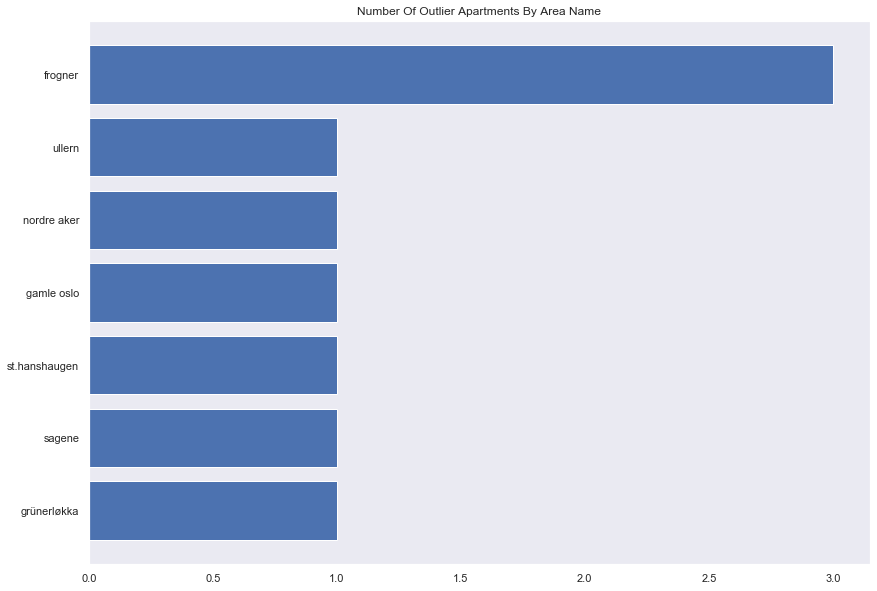

In [58]:
to_sub_plot = to_plot.area_name.value_counts(ascending=True)
plt.yticks(range(len(to_sub_plot)), to_sub_plot.index)
plt.title('Number Of Outlier Apartments By Area Name')
plt.barh(range(len(to_sub_plot)), to_sub_plot)
plt.show()

Most of the outliers are located in the most expensive area in Oslo. It looks that the high price is not due to a data anomaly, but to the apartments being in expensive neighborhood.

Let us now go back to our full dataset and look at two more characteristics (new buildings and ownership type):

In [61]:
# fig = plt.figure(figsize=(16, 8))
# for i, c in enumerate(['new_building', 'ownership_type']):
#     ax = plt.subplot(1, 2, i+1)
#     sns.boxplot(data=data, x=c, y='price_per_sq_m', color='b')
#     ax.set_title(f'Per {c}')
# plt.suptitle('Price Distribution')
# plt.show()

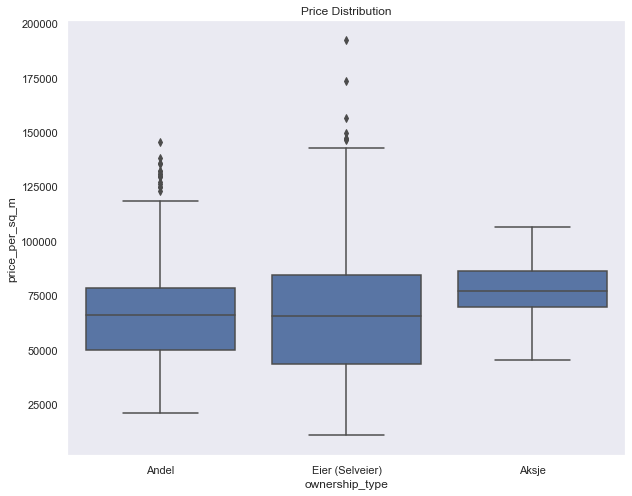

In [64]:
fig = plt.figure(figsize=(10, 8))
sns.boxplot(data=data, x='ownership_type', y='price_per_sq_m', color='b')
plt.title('Price Distribution')
plt.show()

In [65]:
data['ownership_full'] = [1 if ownership_type == 'Eier (Selveier)' else 0 for ownership_type in data.ownership_type]

The ownership type seems to matter mostly regarding very expensive properties. New buildings seem to have a higher price, however their distribution has a lower standard deviation.

We can now investigate the price distribution per floor.

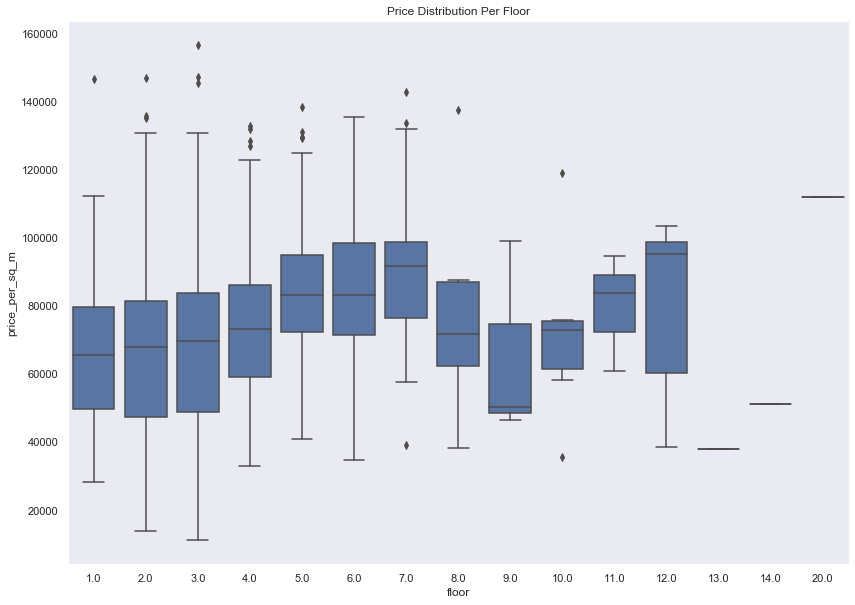

In [66]:
sns.boxplot(data=data, x='floor', y='price_per_sq_m', color='b')
plt.title('Price Distribution Per Floor')
plt.show()

It seems that the higher the floor - the more expensive the apartment. However it is possible that the selection of apartments on high floors is quite thin. Let us confirm that.

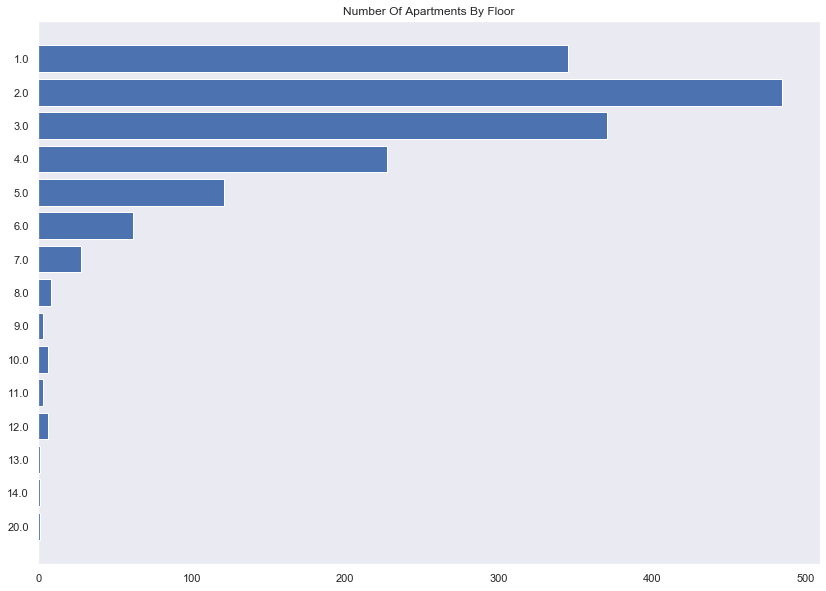

In [67]:
to_plot = data.floor.value_counts().sort_index(ascending=False)
plt.yticks(range(len(to_plot)), to_plot.index)
plt.title('Number Of Apartments By Floor')
plt.barh(range(len(to_plot)), to_plot)
plt.show()

As we expected, there are a handful of apartments on floors higher than the 10th floor. However the trend line for floors below the 10th is still valid. There are two more variables left to investigate from this dataset: the `num_bedrooms` and the `primary_size`.

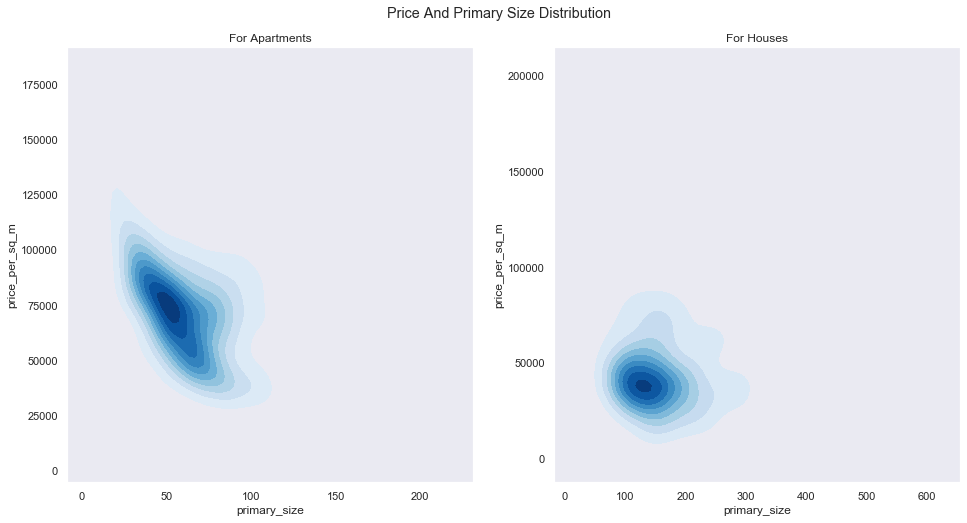

In [68]:
fig = plt.figure(figsize=(16, 8))
for i, a in enumerate(data.property_type_apartment.unique()):
    ax = plt.subplot(1, 2, i+1)
    to_plot = data[data.property_type_apartment == a]
    sns.kdeplot(to_plot.primary_size, to_plot.price_per_sq_m, cmap='Blues', shade=True, shade_lowest=False)
    ax.set_title('For {}'.format('Apartments' if a == 1 else 'Houses'))

plt.suptitle('Price And Primary Size Distribution', y=0.95)
plt.show()

It is difficult to identify any dependency based on the size (this, of course is expected az size is already factored in the target). Now let us investigate our final variable from this dataset.

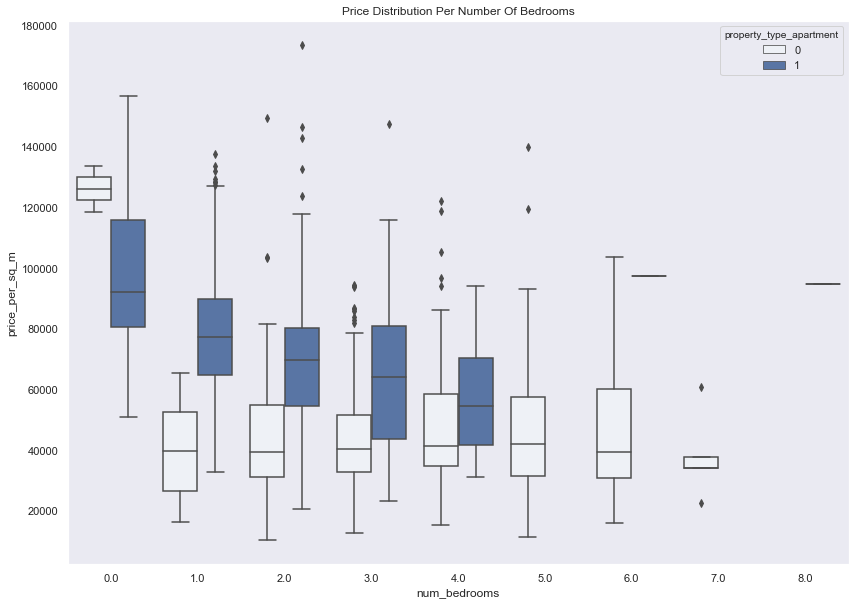

In [69]:
sns.boxplot(data=data, x='num_bedrooms', y='price_per_sq_m', hue='property_type_apartment', color='b')
plt.title('Price Distribution Per Number Of Bedrooms')
plt.show()

It seems that there is a certain trend between number of bedrooms and the price per square meter ***for apartments***. However there doesn't seem to be any trend when it comes to houses. With this in mind here are our top picks of variables from the main dataset:

In [70]:
real_estate_columns = ['time_s', 'property_type_apartment', 'new_building', 'construction_year', 'ownership_full', 'floor', 'num_bedrooms']

In [71]:
print('The selected columns are: ' + ', '.join(real_estate_columns))

The selected columns are: time_s, property_type_apartment, new_building, construction_year, ownership_full, floor, num_bedrooms


### 2.1.2 Google Places Dataset
This dataset represents records for more than 8700 places in nearly 1000 post codes around Oslo and Akershus. The dataset is built upon multiple calls to the Google Places API. For every geographical center of a post code (represented by the post code's latitude and longitude), a call is made to the Google Places service for a radius of 500 meters around the corresponding point. The response from Google Places contains all places available on Google Maps within the cirlcle as well as their rating and price range (if available). The resulting table looks like this:

In [72]:
gmaps = u.get_data(queries, 'all_post_code_places.sql', bq_client)

In [73]:
gmaps.head()

post_code  radius        place_name         place_type place_attribute  \
0      0001     500              Oslo           locality          rating   
1      0001     500              Oslo          political          rating   
2      0001     500  Oslo Opera House            premise          rating   
3      0001     500  Oslo Opera House  point_of_interest          rating   
4      0001     500  Oslo Opera House      establishment          rating   

   attribute_value  
0              NaN  
1              NaN  
2              NaN  
3              NaN  
4              NaN

We can use this dataset in order to calculate the number of places by place type in each post code. We can also calculate the mean place rating and the number of places in each price range. The rationale behind this is that home prices are influenced by the characteristics of the home, its location as well as the characteristics of the neighborhood. Let us start by a simple count pivot.

In [74]:
_slice = gmaps[gmaps.place_attribute == 'rating']
place_counts = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='count', fill_value=0)

In [75]:
place_counts.head()

place_type  accounting  administrative_area_level_2  airport  amusement_park  \
post_code                                                                      
0001                 0                    0                0               0   
0009                 0                    0                0               0   
0010                 0                    0                0               0   
0014                 0                    0                0               0   
0015                 0                    0                0               0   

place_type  art_gallery  atm  bakery  bank  bar  beauty_salon  bicycle_store  \
post_code                                                                      
0001                  0    0       0     0    0             0              0   
0009                  0    0       0     0    0             0              0   
0010                  0    0       0     0    2             1              0   
0014                  0    0       0     0    0             0              0   
0015                  0    0       0     0    3             0              0   

place_type  book_store  bowling_alley  bus_station  cafe  car_dealer  \
post_code                                                              
0001                 1              0            0     0           0   
0009                 0              0            0     0           0   
0010                 0              0            1     1           0   
0014                 1              0            0     0           0   
0015                 0              0            0     2           0   

place_type  car_rental  car_repair  car_wash  cemetery  ...  rv_park  school  \
post_code                                               ...                    
0001                 0           0         0         0  ...        0       0   
0009                 0           0         0         0  ...        0       0   
0010                 1           0         0         0  ...        0       0   
0014                 0           0         0         0  ...        0       0   
0015                 0           0         0         0  ...        0       0   

place_type  shoe_store  shopping_mall  spa  stadium  storage  store  \
post_code                                                             
0001                 0              0    0        0        0      1   
0009                 0              0    0        0        0      0   
0010                 0              0    1        0        0      2   
0014                 0              0    0        0        0      1   
0015                 0              0    0        0        0      0   

place_type  sublocality  sublocality_level_1  sublocality_level_2  \
post_code                                                           
0001                  0                    0                    0   
0009                  0                    0                    0   
0010                  0                    0                    0   
0014                  0                    0                    0   
0015                  0                    0                    0   

place_type  subway_station  supermarket  taxi_stand  train_station  \
post_code                                                            
0001                     0            0           0              0   
0009                     0            0           0              0   
0010                     0            0           0              1   
0014                     0            0           0              0   
0015                     0            0           0              0   

place_type  transit_station  travel_agency  university  veterinary_care  zoo  
post_code                                                                     
0001                      0              0           0                0    0  
0009                      0              0           0                0    0  
0010                   

Next, we can add mean place rating where such rating is available.

In [76]:
_slice = gmaps[gmaps.place_attribute == 'rating']
place_ratings = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='mean')

We can also calculate the mean price range mark for the places.

In [77]:
_slice = gmaps[gmaps.place_attribute == 'price_level']
place_prices = pd.pivot_table(data=_slice, index='post_code', columns='place_type', values='attribute_value', aggfunc='mean')

Next, we will remove all columns with low variation (some types of places like zoos and universities are way too rare give us consistent information about neighborhoods).

In [78]:
gmaps_data = place_counts.join(place_ratings, rsuffix='_rating').join(place_prices, rsuffix='_price')

In [79]:
gmaps_data.dropna(axis=1, inplace=True)

In [80]:
var_estimator = feature_selection.VarianceThreshold(threshold=0.9)

In [81]:
var_estimator.fit(gmaps_data)

VarianceThreshold(threshold=0.9)

In [82]:
var_features = pd.Series(var_estimator.get_support(), index=gmaps_data.columns)

In [83]:
gmaps_features = list(var_features[var_features == True].index)

In [84]:
print('The selected features based on variance from the Google Maps dataset are: {}.'.format(', '.join(gmaps_features)))

The selected features based on variance from the Google Maps dataset are: establishment, food, health, home_goods_store, lodging, point_of_interest, restaurant, store.


An important point to note is that the concentration of places in the city could be very different from that in suburbia. We will make sure to investigate this trend once we identify the strongest predictors of price amongst the Google Maps features.

With that in mind, let us aggregate the median property price per post code and join it to the selected features from Google Maps.

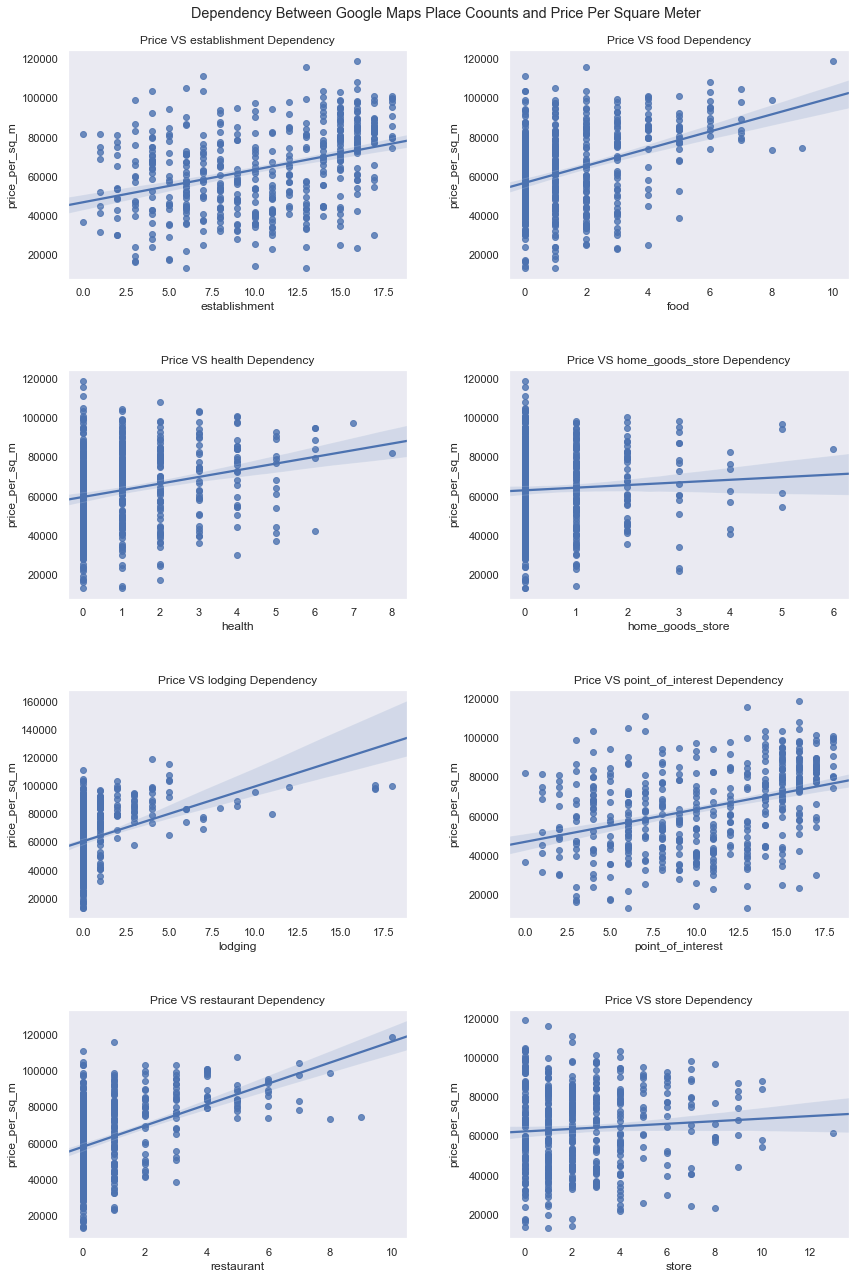

In [85]:
to_plot = pd.pivot_table(data=data,
                         index='post_code',
                         values='price_per_sq_m',
                         aggfunc='median').join(gmaps_data[gmaps_features])

fig = plt.figure(figsize=(14, 20))
cols = 2
rows = int(len(gmaps_features) / cols) + len(gmaps_features) % cols
for i, c in enumerate(gmaps_features):
    ax = plt.subplot(rows, cols, i+1)
    sns.regplot(x=c, y='price_per_sq_m', data=to_plot)
    ax.set_title(f'Price VS {c} Dependency')

plt.subplots_adjust(wspace=0.3, hspace=0.4, top=0.95)
plt.suptitle('Dependency Between Google Maps Place Coounts and Price Per Square Meter')
plt.show()

The most pronounced dependencies seem to be between `price_per_s_m` and: `restaurant`, `lodging` and `food`. Let us investigate the differences between Oslo and suburbia by looking specifically at the dependency between `price_per_s_m` and: `restaurant`.

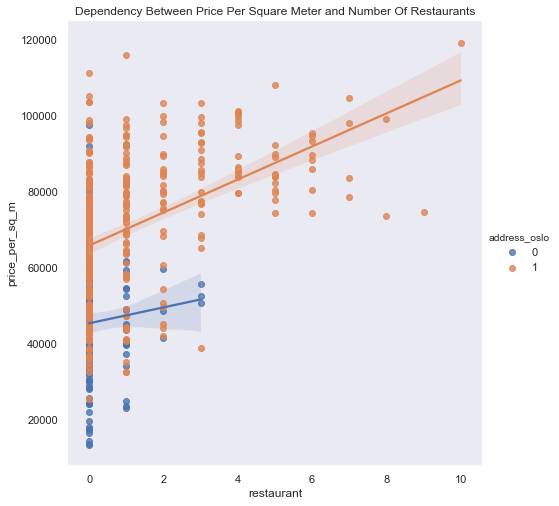

In [86]:
to_plot = pd.pivot_table(data=data,
                         index='post_code',
                         values='price_per_sq_m',
                         aggfunc='median').join(gmaps_data[gmaps_features]).join(data.groupby('post_code')['address_oslo'].min())

g = sns.lmplot(x='restaurant', y='price_per_sq_m', hue='address_oslo', truncate=True, height=7, data=to_plot)

plt.title('Dependency Between Price Per Square Meter and Number Of Restaurants')
plt.show()

As we can see, the dependency is strongest in Oslo. Since the maximum number of restaruants per post code in suburbia is less than 4, it is difficult to conclude if a similar dependency exists there. Still, we will keep the feature.

Next, we want to investigate the relationship between the features themselves. This is because `restaurant`, `food` and `establishment` intuitively seem to imply the same type of place. In order to avoid aplifying the importance of these features artificially, we will check if we can select the most relevant of them in terms of price.

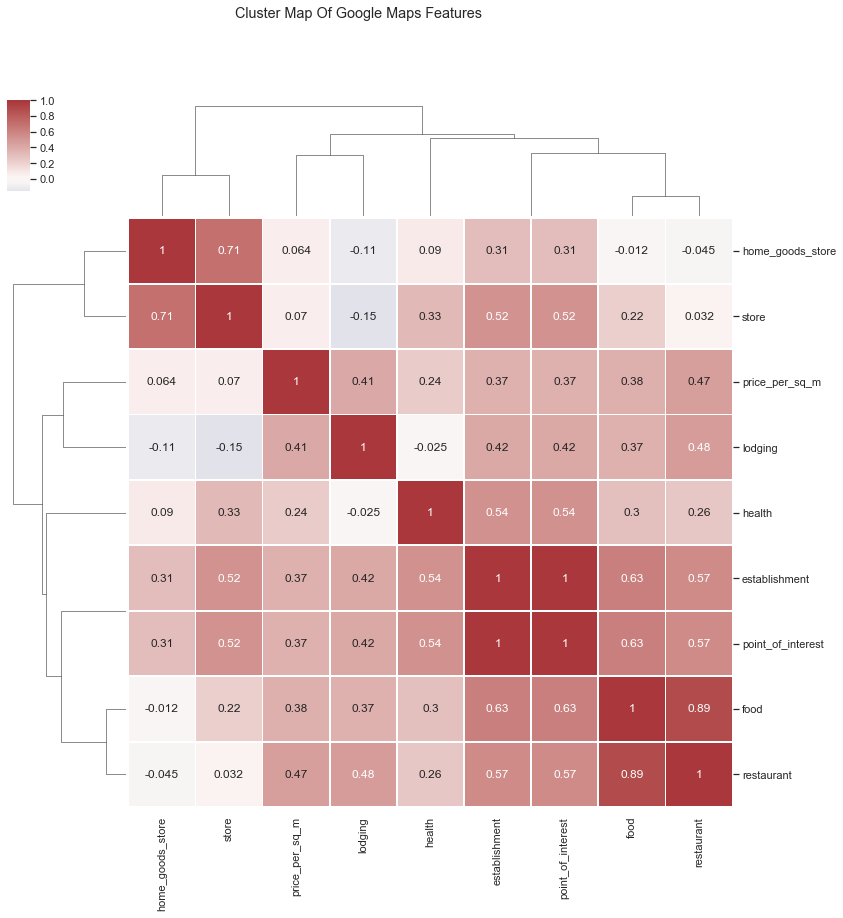

In [87]:
to_plot = pd.pivot_table(data=data,
                         index='post_code',
                         values='price_per_sq_m',
                         aggfunc='median').join(gmaps_data[gmaps_features])

sns.clustermap(to_plot.corr().fillna(0), center=0, cmap='vlag', linewidths=.75, figsize=(13, 13), annot=True)

plt.suptitle('Cluster Map Of Google Maps Features')
plt.show()

As we can see, `food` and `restaurant` are types of `establishment`. In addtition, `establishment` seems to represent the same as `point_of_interest`. On the other hand, `home_goods_store` and `store` seem to represent a similar types of places, however correlating weekly with `price_per_sq_m`. It looks like we can use: `restaurant` and `lodging` to represent `price_per_sq_m` on post code level.

In [88]:
gmaps_features_refined = ['restaurant', 'lodging']

Finally, we can plot the dependency between the number of places in each category and the price.

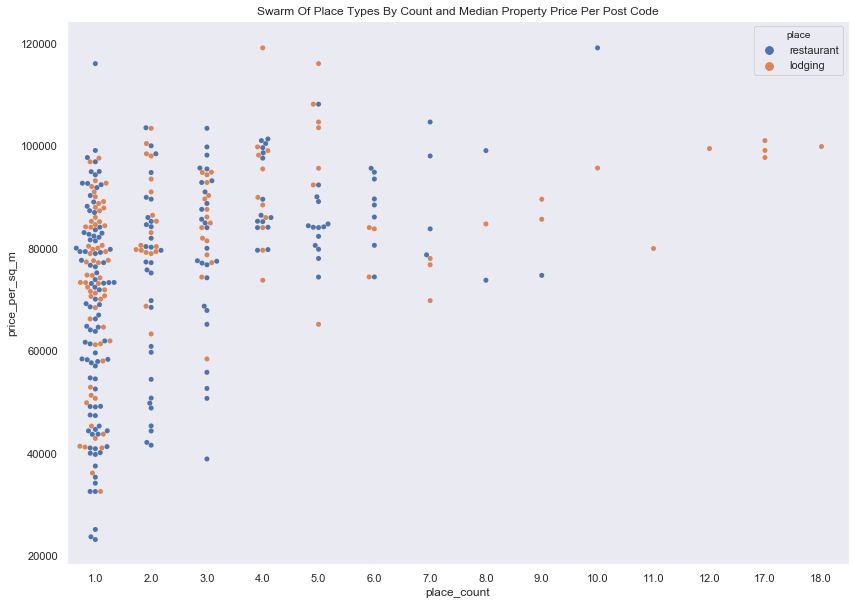

In [89]:
to_plot = pd.pivot_table(data=data,
                         index='post_code',
                         values='price_per_sq_m',
                         aggfunc='median').join(gmaps_data[gmaps_features_refined])

to_plot2 = to_plot.reset_index().melt(id_vars=['post_code', 'price_per_sq_m'], value_vars=gmaps_features_refined, var_name='place', value_name='place_count')

sns.swarmplot(x='place_count', y='price_per_sq_m', hue='place', data=to_plot2[to_plot2.place_count > 0])

plt.title('Swarm Of Place Types By Count and Median Property Price Per Post Code')
plt.show()

There is a visible upward price trend with the increase of restaurants and lodging places.

In [90]:
print('The selected features from the Google Maps dataset are: {}.'.format(', '.join(gmaps_features_refined)))

The selected features from the Google Maps dataset are: restaurant, lodging.


### 2.1.3 National Health Institute (FHI) Dataset
The FHI dataset consists of municipality-level, socio-economic statistics. Each dataset (e.g. immigrant percentage, income inequality, etc.) contains annual values for several different years, for all municipalities of Akershuhs as well as the neighborhoods of Oslo.

In [91]:
nhs = u.get_data(queries, 'full_fhi_data.sql', bq_client)

In [92]:
nhs.head()

dataset      area_name  year  value
0  income_inequality         hurdal  2013  0.023
1  income_inequality  st.hanshaugen  2013  0.038
2  income_inequality        frogner  2013  0.045
3  income_inequality         ullern  2013  0.039
4  income_inequality    vestre aker  2013  0.043

In [93]:
print('The NHS dataset contains data for: {}.'.format(', '.join(nhs.dataset.unique())))

The NHS dataset contains data for: income_inequality, uni_graduates, low_income_households, cramped_spaces, immigrant_pct.


In [94]:
print(f'The NHS dataset contains data from {nhs.year.min()} to {nhs.year.max()}.')

The NHS dataset contains data from 2013 to 2019.


A small complication is that some NHS metrics have varying values for the year of their latest results:

In [95]:
nhs[nhs.value.notna()].groupby('dataset')['year'].max()

dataset
cramped_spaces           2017
immigrant_pct            2019
income_inequality        2017
low_income_households    2016
uni_graduates            2017
Name: year, dtype: int64

To overcome this, we will consecuitively join the latest results for each dataset.

In [96]:
nhs_latest = pd.DataFrame(index=nhs.area_name.unique())
for dataset in nhs.dataset.unique():
    to_join = nhs[nhs.dataset == dataset]
    latest_year = to_join[to_join.value.notna()].year.max()
    to_join_latest_year = to_join[to_join.year == latest_year]
    to_join_pivot = pd.pivot_table(data=to_join_latest_year,
                                   index='area_name',
                                   values='value').rename(columns={'value': dataset})
    nhs_latest = nhs_latest.join(to_join_pivot)

In [97]:
nhs_latest.head()

income_inequality  uni_graduates  low_income_households  \
hurdal                     0.025           0.35                0.168     
st.hanshaugen              0.038           0.73                0.186     
frogner                    0.047           0.72                0.160     
ullern                     0.040           0.76                0.066     
vestre aker                0.045           0.77                0.069     

               cramped_spaces  immigrant_pct  
hurdal                  0.128          0.103  
st.hanshaugen           0.469          0.278  
frogner                 0.328          0.280  
ullern                  0.160          0.199  
vestre aker             0.140          0.178

We start our investigation by taking an overall look at all FHI metrics and their relatioship to the median `price_per_sq_m` per area.

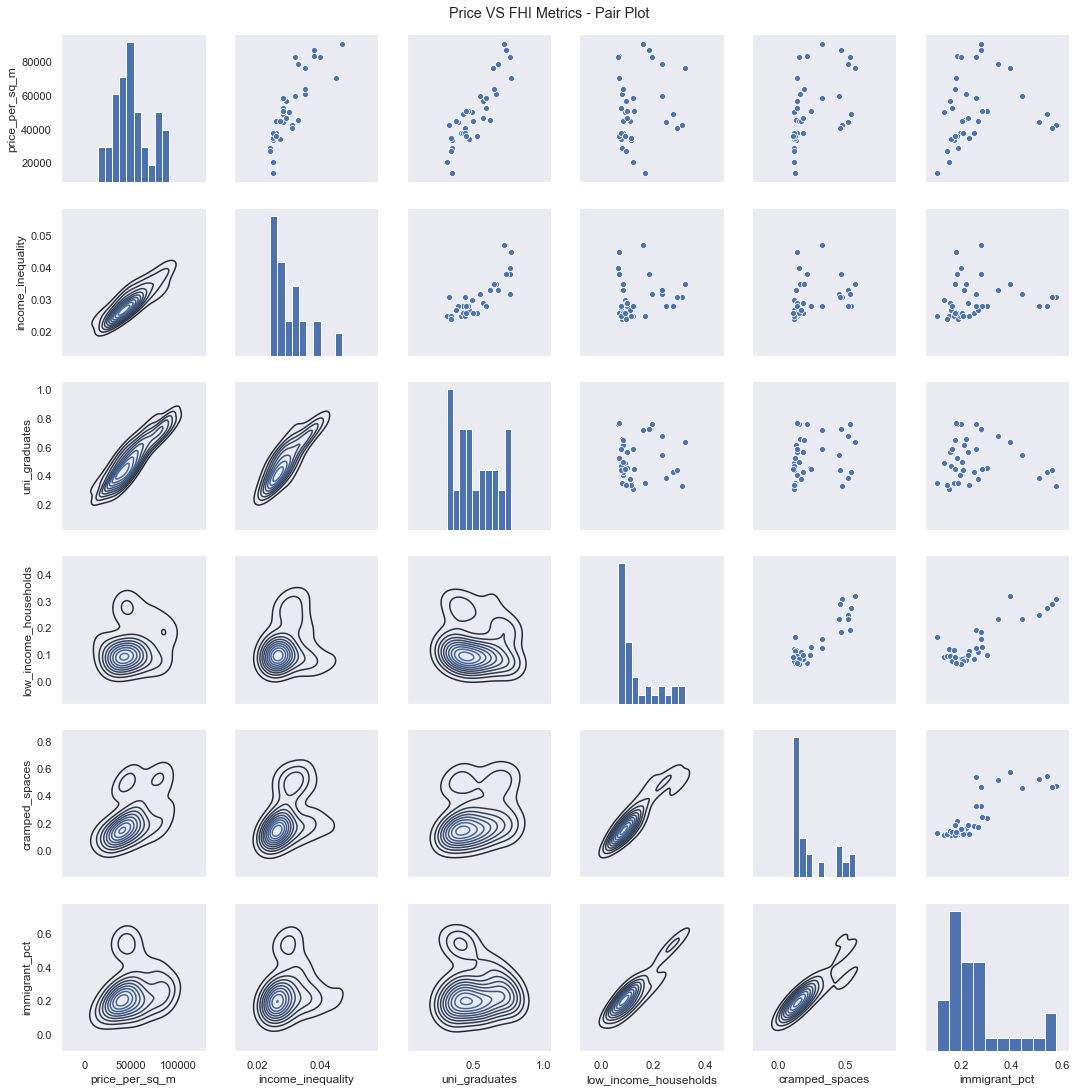

In [98]:
to_plot = pd.pivot_table(data=data,
                         index='area_name',
                         values='price_per_sq_m',
                         aggfunc='median').join(nhs_latest)

g = sns.PairGrid(to_plot.dropna(), diag_sharey=False)
g.map_lower(sns.kdeplot)
g.map_upper(sns.scatterplot)
g.map_diag(plt.hist)
plt.suptitle('Price VS FHI Metrics - Pair Plot', y=1.01)
plt.show()

There seems to be a linear pattern on the scatterplots involving `price_per_sq_m`, `income_inequality` and `uni_graduates`. We can explore these in more detail.

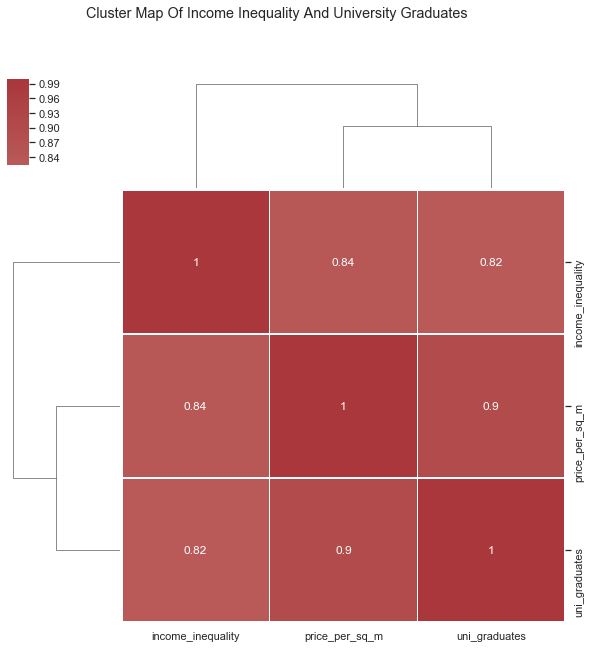

In [99]:
to_plot = pd.pivot_table(data=data,
                         index='area_name',
                         values='price_per_sq_m',
                         aggfunc='median').join(nhs_latest)

sns.clustermap(to_plot[['price_per_sq_m', 'income_inequality', 'uni_graduates']].corr(), center=0, cmap='vlag', linewidths=.75, figsize=(10, 10), annot=True)

plt.suptitle('Cluster Map Of Income Inequality And University Graduates')
plt.show()

As we can see, the `income_inequality` and `uni_graduates` features correlate strongly with each other. Therefore, we can select one of them (`uni_graduates`). This concludes our data exploration.

In [100]:
nhs_features = ['uni_graduates']

In [101]:
all_features = real_estate_columns + gmaps_features_refined + nhs_features

In [102]:
print('The selected features are: {}.'.format(', '.join(all_features)))

The selected features are: time_s, property_type_apartment, new_building, construction_year, ownership_full, floor, num_bedrooms, restaurant, lodging, uni_graduates.
